# Getting started with Captum 

In this tutorial we demonstrate how to apply feature attribution methods to graphs. Specifically, we try to find the most important nodes and edges for each instance prediction.

We use cora dataset from dgl.data. The Cora dataset used in this tutorial only consists of one single graph.

In [1]:
# Install and import required packages.
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from dgl.nn import GraphConv

## Loading Cora Dataset

In [2]:
# A DGL Dataset object may contain one or multiple graphs.
# The Cora dataset used in this tutorial only consists of one single graph.
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


## Define the model
This tutorial will build a two-layer Graph Convolutional Network (GCN). Each layer computes new node representations by aggregating neighbor information. What's more, we use GraphConv which supports edge_weight as a parameter.

In [3]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, in_feat, g, edge_weight=None):
        h = self.conv1(g, in_feat, edge_weight=edge_weight)
        h = F.relu(h)
        h = self.conv2(g, h, edge_weight=edge_weight)
        return h

## Training the model
Training this GCN is similar to training other PyTorch neural networks.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes).to(device)
g = g.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']

for epoch in range(1,201):
    model.train()
    optimizer.zero_grad()
    # Forward
    logits = model(features, g)
    
    # Compute prediction
    pred = logits.argmax(1)
    
    # Compute loss
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    # Backward
    loss.backward()
    optimizer.step()

/Users/yingpei/opt/anaconda3/envs/dgl/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


## Explaining the predictions
We use the [captum](https://captum.ai/) library for calculating the attribution values.

In [5]:
# Select the node with index 10 for interpretability analysis
output_idx = 10
target = int(g.ndata['label'][output_idx])
print(target)

0


In [6]:
# import captum
from captum.attr import IntegratedGradients
from functools import partial

# Node explainability
ig = IntegratedGradients(partial(model.forward, g=g))
ig_attr_node = ig.attribute(g.ndata['feat'], target=target,
                            internal_batch_size=g.num_nodes(), n_steps=50)
print(ig_attr_node.shape)

/Users/yingpei/opt/anaconda3/envs/dgl/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


torch.Size([2708, 1433])


In [7]:
# Scale attributions to [0, 1]:
ig_attr_node = ig_attr_node.abs().sum(dim=1)
ig_attr_node /= ig_attr_node.max()

In [8]:
# Visualize

In [9]:
ig_attr_node

tensor([0.1432, 0.1575, 0.2716,  ..., 0.1867, 0.1472, 0.1620],
       dtype=torch.float64)

In [10]:
def model_forward(edge_mask, g):
    out = model(g.ndata['feat'],g,edge_weight=edge_mask)
    return out

# Edge explainability
edge_mask = torch.ones(g.num_edges()).requires_grad_(True).to(device)
ig = IntegratedGradients(partial(model_forward, g=g))
ig_attr_edge = ig.attribute(edge_mask, target=target,
                            internal_batch_size=g.num_nodes(), n_steps=50)
print(ig_attr_edge.shape)

/Users/yingpei/opt/anaconda3/envs/dgl/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 10556 equal to the number of examples.
  warnings.warn(


torch.Size([10556])


In [11]:
# Scale attributions to [0, 1]:
g_attr_edge = ig_attr_edge.abs()
ig_attr_edge /= ig_attr_edge.max()

In [12]:
# Visualize

In [13]:
ig_attr_edge

tensor([-0.2002, -0.2037, -0.2239,  ..., -0.0117, -0.0499, -0.0479],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [14]:
num_hops = 2
sg, inverse_indices = dgl.khop_in_subgraph(g, output_idx, num_hops)

In [17]:
NID,EID='_ID','_ID'
subset = sg.ndata[NID].long()
subset

tensor([  10,  306,  476, 1140, 1800, 1986, 2545])

In [18]:
node_alpha_subset = ig_attr_node[subset]
node_alpha_subset

tensor([0.2419, 0.5737, 0.2293, 0.0930, 0.1227, 0.7369, 0.1365],
       dtype=torch.float64)

In [19]:
sg_edges = sg.edata[EID].long()
edge_mask = ig_attr_edge.gather(0,sg_edges)
edge_mask

tensor([ 0.2360,  0.3247,  0.0110,  0.2264,  0.0921,  0.1187,  0.2134,  0.1760,
         0.2225,  0.0355, -0.0294,  0.2262], dtype=torch.float64,
       grad_fn=<GatherBackward0>)

In [20]:
sg.edata['attr'] = edge_mask

In [21]:
import networkx as nx
from inspect import signature
nx_g = sg.to_networkx(edge_attrs=['attr'])
mapping = {k: i for k, i in enumerate(subset.tolist())}
nx_g = nx.relabel_nodes(nx_g, mapping)

kwargs = {}
node_args = set(signature(nx.draw_networkx_nodes).parameters.keys())
node_kwargs = {k: v for k, v in kwargs.items() if k in node_args}
node_kwargs['node_size'] = kwargs.get('node_size') or 800
node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

label_args = set(signature(nx.draw_networkx_labels).parameters.keys())
label_kwargs = {k: v for k, v in kwargs.items() if k in label_args}
label_kwargs['font_size'] = kwargs.get('font_size') or 10

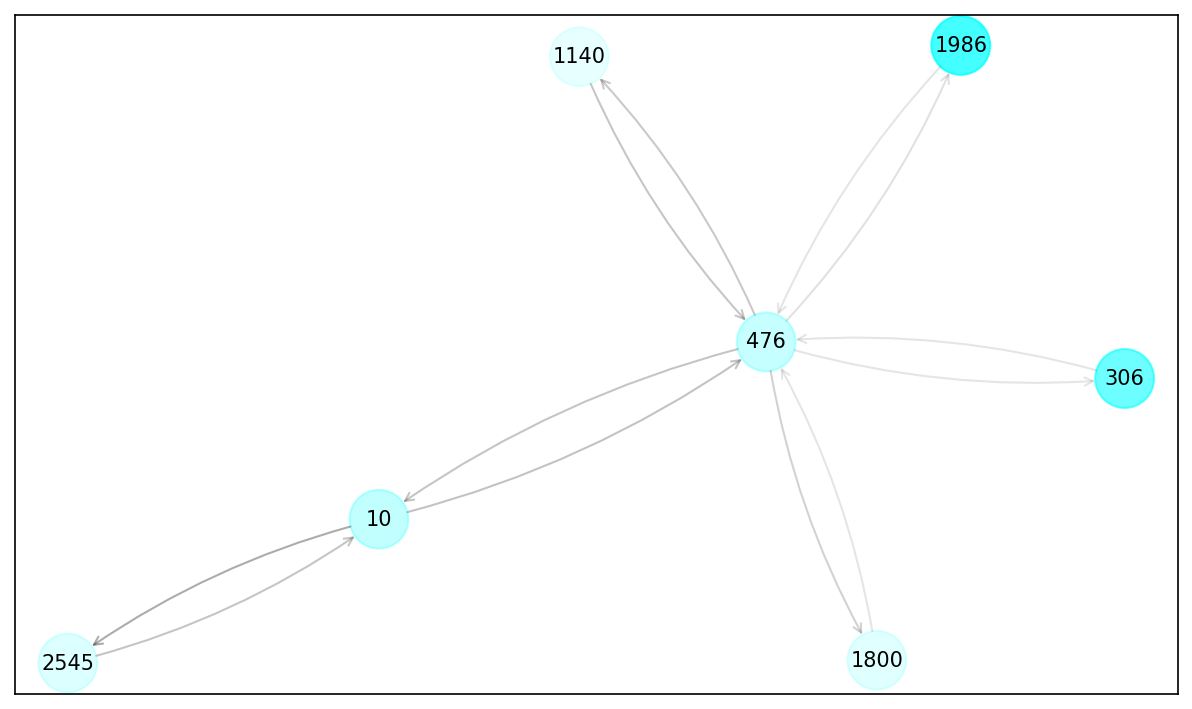

In [27]:
import matplotlib.pyplot as plt
from math import sqrt
plt.figure(figsize=(10, 6), dpi=150)
pos = nx.spring_layout(nx_g, seed=10)
ax = plt.gca()
for source, target, data in nx_g.edges(data=True):
    ax.annotate(
        '', xy=pos[target], xycoords='data', xytext=pos[source],
        textcoords='data', arrowprops=dict(
            arrowstyle="->",
            alpha=max(data['attr'].item(), 0.1),
            color='black',
            shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
            shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
            connectionstyle="arc3,rad=0.1",
        ))
y = [0] * sg.number_of_nodes()
nx.draw_networkx_nodes(nx_g, pos, alpha=node_alpha_subset.tolist(),node_color=y, **node_kwargs)
nx.draw_networkx_labels(nx_g, pos, **label_kwargs)
plt.show()